### Fitting model description
1. 1 Voigt function for elastic, FWHM_G = 16.89, FWHM_L = 9
2. 1 pure Lorentzian function for CDF, without convolution. 
3. *3* Voigt functions for phonons, FWHM the same as the elastic
4. 1 quadratic function for background

In [2]:
import sys 
sys.path.append('codes')
from scipy.optimize import curve_fit
import MyFunctions as mf
import matplotlib.pyplot as plt
import rixs_tools as rt
from scipy.signal import convolve
import numpy as np
from rixs_experiment import RIXS_EXP 
System = rt.create_system()

In [3]:
exp = RIXS_EXP()

AttributeError: 'dict' object has no attribute 'fitting_info'

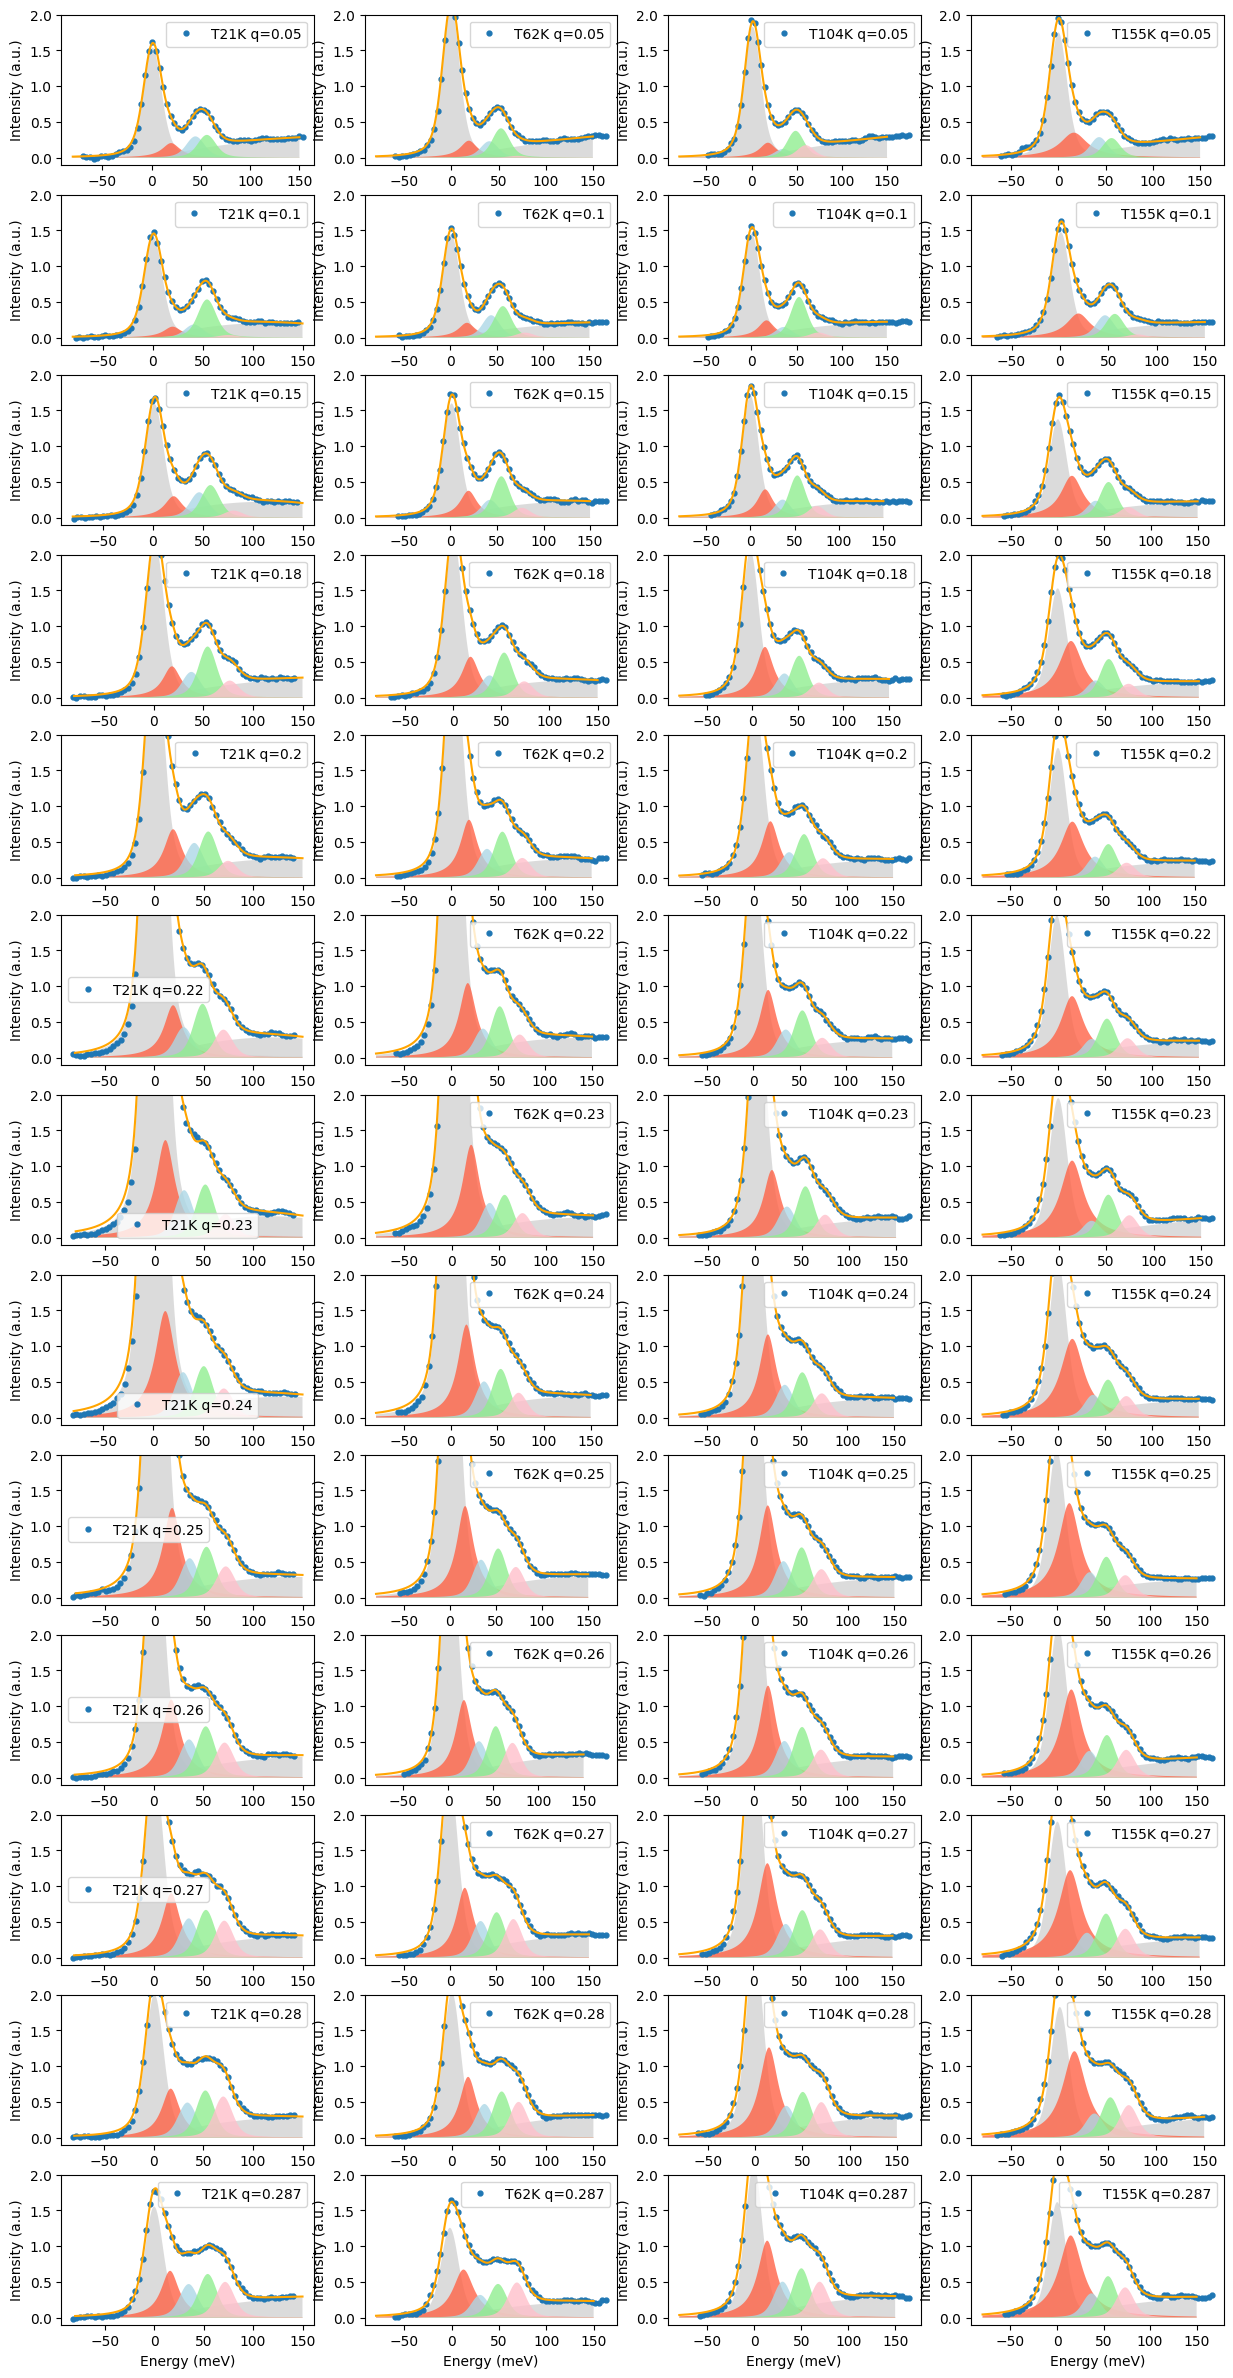

In [6]:
# basic fitting
fL = exp._fL_preset
fG = exp._fG_preset
global T

def fun_DHO_bose(x,x0,A,res):
    return mf.fun_DHO_original(x,x0,A,res) * 1/(1+np.exp(-x/T))

def function_to_fit(x, *parameters):
    res = exp._resolution
    global T
    y1 = mf.fun_voigt(x, *parameters[0:4])  # elastic
    # y2 = fun_DHO_bose(x,*parameters[4:7]) # CDF
    # y2 = mf.fun_DHO(x,*parameters[4:7]) # CDF
    # y2 = mf.convoluted_fun(x, res, mf.fun_DHO, *parameters[4:7]) # CDF
    y2 = mf.fun_lorentzian(x, *parameters[4:7]) # CDF
    # y2 = mf.fun_gaussian(x, *parameters[4:7]) # CDF
    y3 = mf.fun_voigt(x, *parameters[7:9], *parameters[2:4]) # 1st phonon 
    y4 = mf.fun_voigt(x, *parameters[9:11], *parameters[2:4]) # 2nd phonon
    y5 = mf.fun_voigt(x, *parameters[11:13], *parameters[2:4]) # 3rd phonon
    y6 = mf.fun_quadratic(x, *parameters[13:15])# background
    return y1+y2+y3+y4+y5+y6 



#temperature_chars = ['T104K']
temperature_chars = exp._temperature_list_string
res = exp._resolution
fig, axs = plt.subplots(13,4,figsize=(15,30))
for i,temperature_char in enumerate(temperature_chars):
    T = exp._temperature_list_meV[i]

    popt =      [0, 5, fG, fL,\
                10, 0.34, 23,\
                40, 0.17,\
                52, 0.5,\
                75, 0.1,\
                160, 0.2]
    for q_index in range(exp._q_size):
        ax = axs[q_index,i]

        # test the function
        x = np.linspace(-80,150,1000)

        f_epsilon = 0.1
        epsilon = 0.01
        parameters_guess = popt

        parameters_lower = [-5, 0, fG-f_epsilon, fL-f_epsilon,\
                            0, 0, res, \
                            30, 0,\
                            40, 0,\
                            60, 0,\
                            100, 0]
        parameters_upper = [5, 10, fG+f_epsilon, fL+f_epsilon,\
                            40, 2, 100,\
                            55, 3,\
                            70, 3,\
                            105, 3,\
                            500, 3]

        popt, perr = exp.basic_fit(temperature_char, q_index, function_to_fit, parameters_guess, parameters_bound=(parameters_lower, parameters_upper))        
        exp.Fit_results[temperature_char]['optimized_parameters'][q_index] = popt
        exp.Fit_results[temperature_char]['errors'][q_index] = perr
        exp.Fit_results[temperature_char]['fitting_info'] = "voigt for background, lorentzian for CDF, voigt for 3 phonons, quadratic for background"
        exp.plot_data(temperature_char, q_index, ax = ax)
        exp.plot_fit_conponent(function_to_fit, popt, ax = ax, fill = False, label = 'fit', color = 'orange') # total fit
        exp.plot_fit_conponent(mf.fun_voigt, popt[0:4], ax = ax, fill = True, label = 'elastic', color = 'lightgrey') # elastic
        exp.plot_fit_conponent(mf.fun_quadratic, popt[13:15], ax = ax, fill = True, label = 'background', color = 'lightgrey') # background
        #exp.plot_fit_conponent(mf.fun_DHO, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato') # CDF
        # exp.plot_fit_conponent(mf.convoluted_fun, [res,mf.fun_DHO, *popt[4:7]], ax = ax, fill = True, label = 'CDF', color = 'tomato') # CDF
        exp.plot_fit_conponent(mf.fun_lorentzian, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato')
        #exp.plot_fit_conponent(mf.fun_gaussian, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato')
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[7:9],*popt[2:4]], ax = ax, fill = True, label = '1st phonon', color = 'lightblue') # 1st phonon
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[9:11],*popt[2:4]], ax = ax, fill = True, label = '2nd phonon', color = 'lightgreen') # 2nd phonon
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[11:13],*popt[2:4]], ax = ax, fill = True, label = '3rd phonon', color = 'pink') # 3rd phonon
        ax.set_ylim(-0.1,2)

exp.Fit_results.fitting_info = "voigt for elastic, Lorentzian for CDF, voigt for 3 phonons with the same fG and fL as elastic, quadratic for background"


In [ ]:
res

22.22

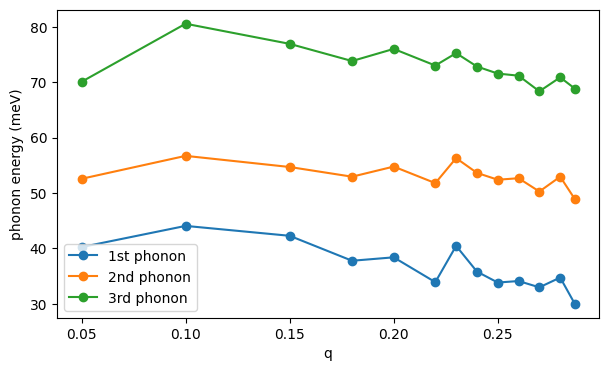

In [ ]:
# plotting the first fitting parameter for each phonons as a function of q at 21K
fig, ax = plt.subplots(1,1,figsize=(7,4))
temperature_char = 'T62K'
phonon1_energy = np.zeros(exp._q_size)
phonon2_energy = np.zeros(exp._q_size)
phonon3_energy = np.zeros(exp._q_size)
for q_index in range(exp._q_size):
    phonon1_energy[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][7]
    phonon2_energy[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][9]
    phonon3_energy[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][11]

ax.plot(exp._q_list, phonon1_energy, '-o', label = '1st phonon')
ax.plot(exp._q_list, phonon2_energy, '-o', label = '2nd phonon')
ax.plot(exp._q_list, phonon3_energy, '-o', label = '3rd phonon')
ax.set_xlabel('q')
ax.set_ylabel('phonon energy (meV)')
ax.legend()


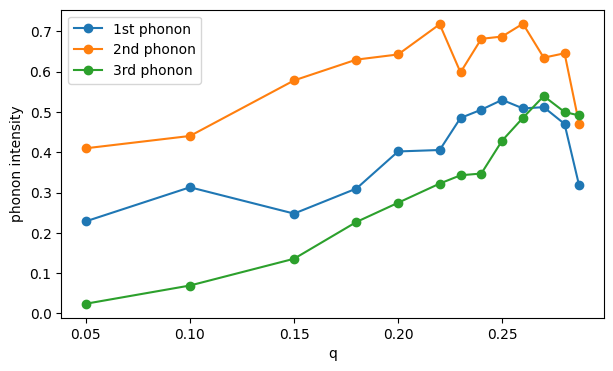

In [ ]:
# plotting the second fitting parameter for each phonons as a function of q at 21K
fig, ax = plt.subplots(1,1,figsize=(7,4))
phonon1_intensity = np.zeros(exp._q_size)
phonon2_intensity = np.zeros(exp._q_size)
phonon3_intensity = np.zeros(exp._q_size)
for q_index in range(exp._q_size):
    phonon1_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][8]
    phonon2_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][10]
    phonon3_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][12]

ax.plot(exp._q_list, phonon1_intensity, '-o', label = '1st phonon')
ax.plot(exp._q_list, phonon2_intensity, '-o', label = '2nd phonon')
ax.plot(exp._q_list, phonon3_intensity, '-o', label = '3rd phonon')
ax.set_xlabel('q')
ax.set_ylabel('phonon intensity')
ax.legend()


In [7]:
print(f" FWHM at 155K is {exp.Fit_results['T155K']['optimized_parameters'][8][6]}")
print(f" FWHM at 104K is {exp.Fit_results['T104K']['optimized_parameters'][8][6]}")
print(f" FWHM at 62K is {exp.Fit_results['T62K']['optimized_parameters'][8][6]}")
print(f" FWHM at 21K is {exp.Fit_results['T21K']['optimized_parameters'][8][6]}")

 FWHM at 155K is 28.347285275512377
 FWHM at 104K is 22.220000000000002
 FWHM at 62K is 22.220000000000002
 FWHM at 21K is 22.220000000000002


### remarks
1. from 21K - 104K the FWHM of Lorentzian is the resolution.
2. This means that we can't get the "*original*" FWHM by deconvoluting it with a Gaussian
3. 3-phonon fitting might not work here if we want to extract the $\Delta$ and $\Gamma$ information of the CDF


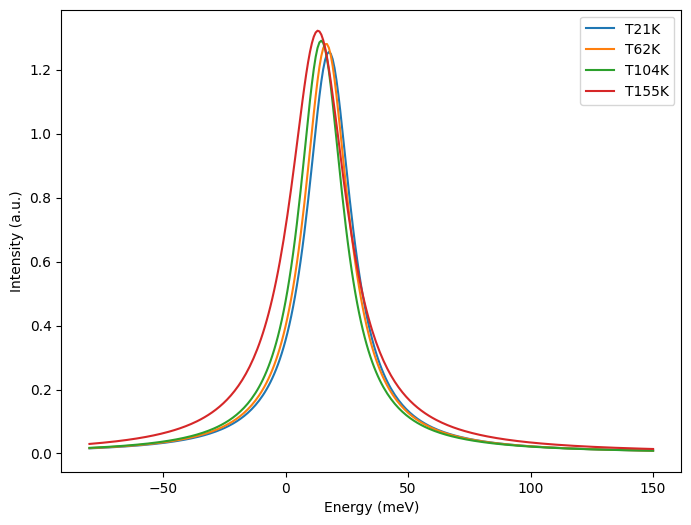

In [8]:
cdf_index = 8
# plot the CDF ay different temperatures
fig, ax = plt.subplots(1,1,figsize=(8,6))
for i,temperature_char in enumerate(temperature_chars):
    popt = exp.Fit_results[temperature_char]['optimized_parameters'][cdf_index]
    exp.plot_fit_conponent(mf.fun_lorentzian, popt[4:7], ax = ax, fill = False, label = temperature_char, color='C'+str(i))
    
ax.set_xlabel('Energy (meV)')
ax.set_ylabel('Intensity (a.u.)')
ax.legend()

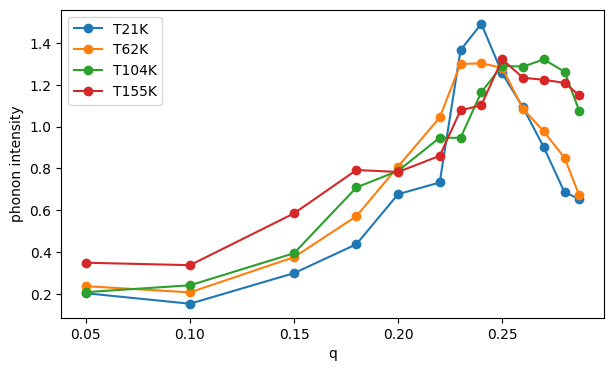

In [9]:
# plotting the second fitting parameter for each phonons as a function of q at T
fig, ax = plt.subplots(1,1,figsize=(7,4))
CDF_intensity = dict( T21K = np.zeros(exp._q_size), T62K = np.zeros(exp._q_size), T104K = np.zeros(exp._q_size), T155K = np.zeros(exp._q_size))
for temperature_char in exp._temperature_list_string:
    for q_index in range(exp._q_size):
        CDF_intensity[temperature_char][q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][5]
    ax.plot(exp._q_list, CDF_intensity[temperature_char], '-o', label = temperature_char)
ax.set_xlabel('q')
ax.set_ylabel('phonon intensity')
ax.legend()


22.220000000000002


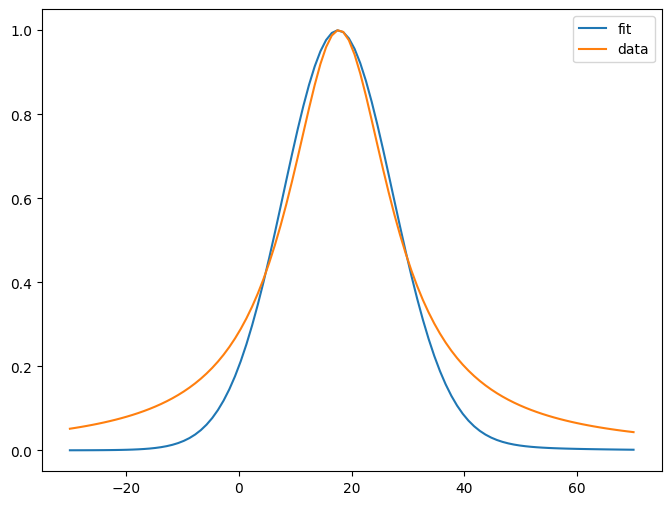

In [ ]:
def fun_chi(x,A,Gamma,Delta):
        normalization_factor = 1/2 * 1/np.sqrt(Delta**2)
        chi = 1/(Delta**2 - (x + 1j*(Gamma))**2)
        return np.imag(chi * normalization_factor)*A

def fun_S(x,A,Gamma,Delta,T):
    return 2/(1-np.exp(-x/T))*fun_chi(x,A,Gamma,Delta)

def fun_S_convoluted(x,Gamma,Delta,T):
    x_left = min(x)
    x_right = max(x)
    x_left_shifted = x_left - (x_right + x_left)/2
    x_right_shifted = x_right - (x_right + x_left)/2
    x_gaussian = np.linspace(x_left_shifted,x_right_shifted,len(x))
    res = exp._resolution
    y = fun_S(x,1,Gamma,Delta,T)
    y_conv = convolve(y, mf.fun_gaussian(x_gaussian,0,1,res), mode='same')
    return y_conv/max(y_conv)
    


# fit CDF with fun_S_convoluted
cdf_index = 8
fig, ax = plt.subplots(1,1,figsize=(8,6))
temperature_char = 'T21K'
temperature = 21*0.086
popt = exp.Fit_results[temperature_char]['optimized_parameters'][cdf_index]
# fit the CDF with fun_S_convoluted
x_data = np.linspace(-30,70,100)
y_data = mf.fun_lorentzian(x_data,*popt[4:7])
print(popt[6])
y_data = y_data/max(y_data)
p0 = [0.2,5,temperature]
epsilon = 0.01
bounds = ([0,0,temperature],[30,30,temperature+epsilon])
sigma = np.ones(len(x_data))
sigma[(x_data>0)&(x_data<30)] = 0.3
popt, pcov = curve_fit(fun_S_convoluted, x_data, y_data, p0 = p0, bounds=bounds,sigma = sigma)


ax.plot(x_data, fun_S_convoluted(x_data,*popt), label = 'fit')
ax.plot(x_data, y_data, label = 'data')
ax.legend()


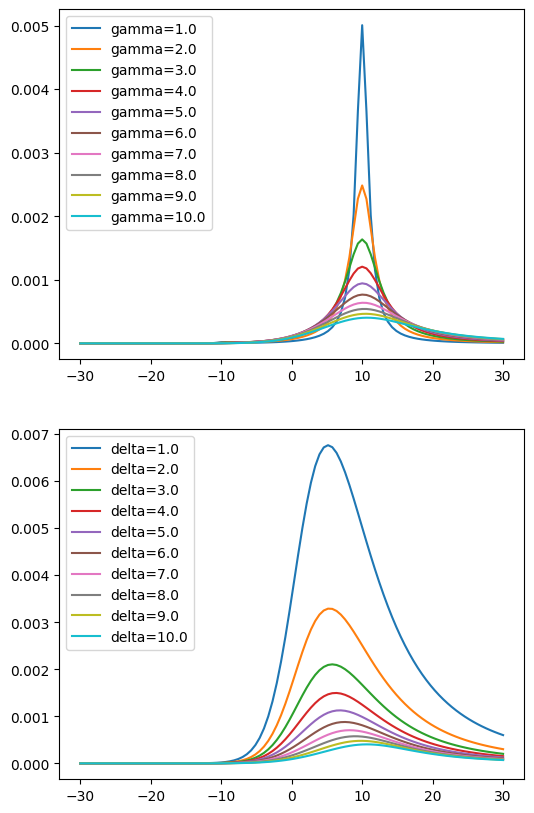

In [ ]:
#plot fun_S with different gamma and delta and with a fixed temperature and A=1
# write a for loop to do it
fig, axs = plt.subplots(2,1,figsize=(6,10))
gamma_list = np.linspace(1,10,10)
delta_list = np.linspace(1,10,10)
temperature = 21*0.086
A=1

for i,gamma in enumerate(gamma_list):
    delta = 10
    ax = axs[0]
    x = np.linspace(-30,30,100)
    y = fun_S(x,A,gamma,delta,temperature)
    ax.plot(x,y,label='gamma='+str(gamma))
    ax.legend()
for i,delta in enumerate(delta_list):
    gamma = 10
    ax = axs[1]
    x = np.linspace(-30,30,100)
    y = fun_S(x,A,gamma,delta,temperature)
    ax.plot(x,y,label='delta='+str(delta))
    ax.legend()







# Problems
1. The FWHM of the CDF is too close to the resolution. Super hard to extract the FWHM before convolution because it's too close to zero. Hard to fit...